# Payments prediction with Neural Network

In this notebook we shall provide the prediction of default payments made by clients in Taiwan from April to Semptember 2005. The execution of the Neural Network will be made step by step.

## Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16,10

RANDOM_SEED = 60

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
X_test = pd.read_csv('data/X_test.csv')
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

## Exploration

In [3]:
print(f"Shape x test {X_test.shape}")
print(f"Shape x train {X_train.shape}")
print(f"Shape y train {y_train.shape}")

Shape x test (6000, 24)
Shape x train (24000, 24)
Shape y train (24000, 2)


In [4]:
X_train.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [5]:
X_test.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [6]:
y_train.columns

Index(['ID', 'default.payment.next.month'], dtype='object')

<AxesSubplot:xlabel='default.payment.next.month', ylabel='count'>

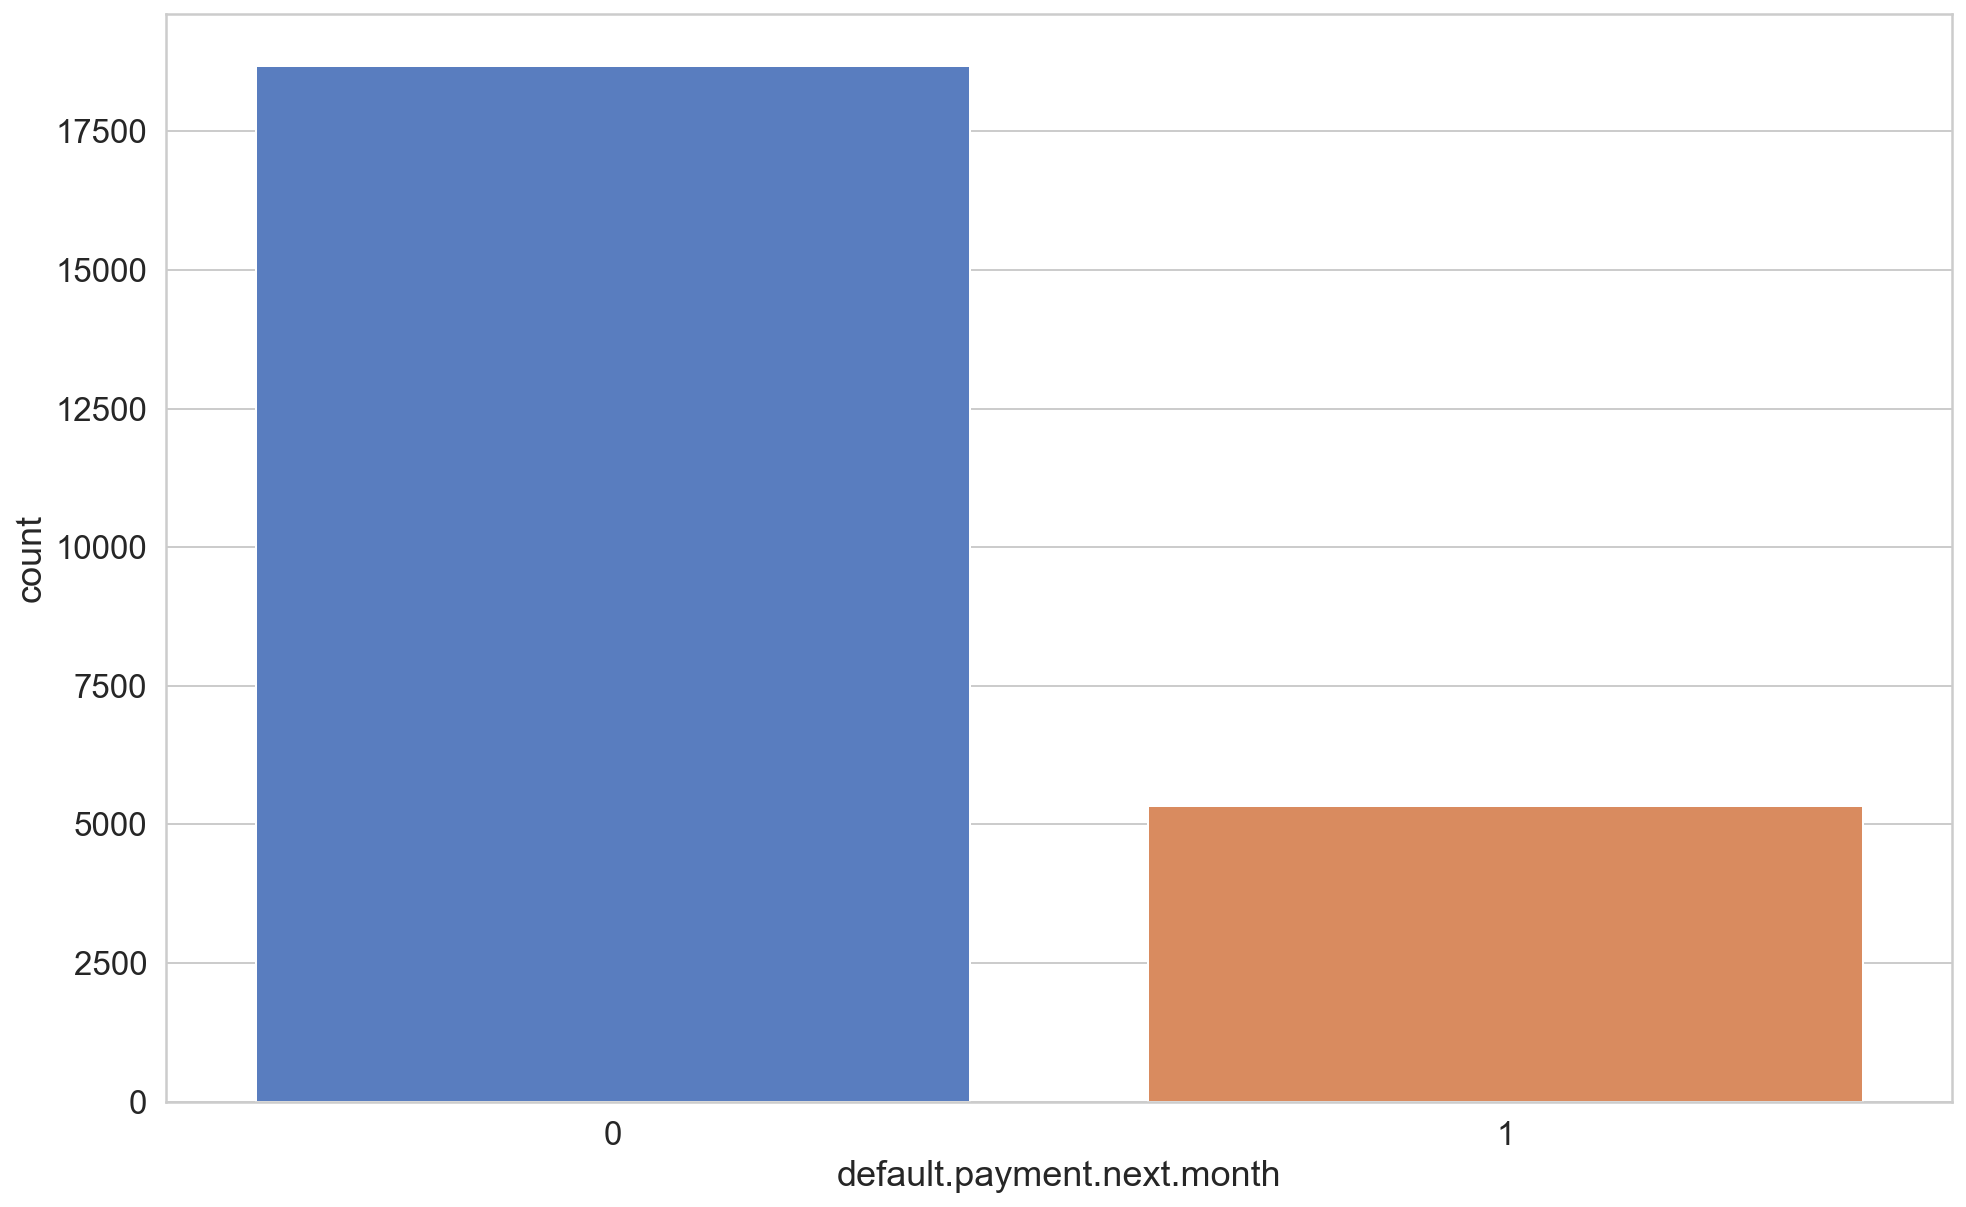

In [7]:
sns.countplot(y_train['default.payment.next.month'])

<AxesSubplot:xlabel='SEX', ylabel='count'>

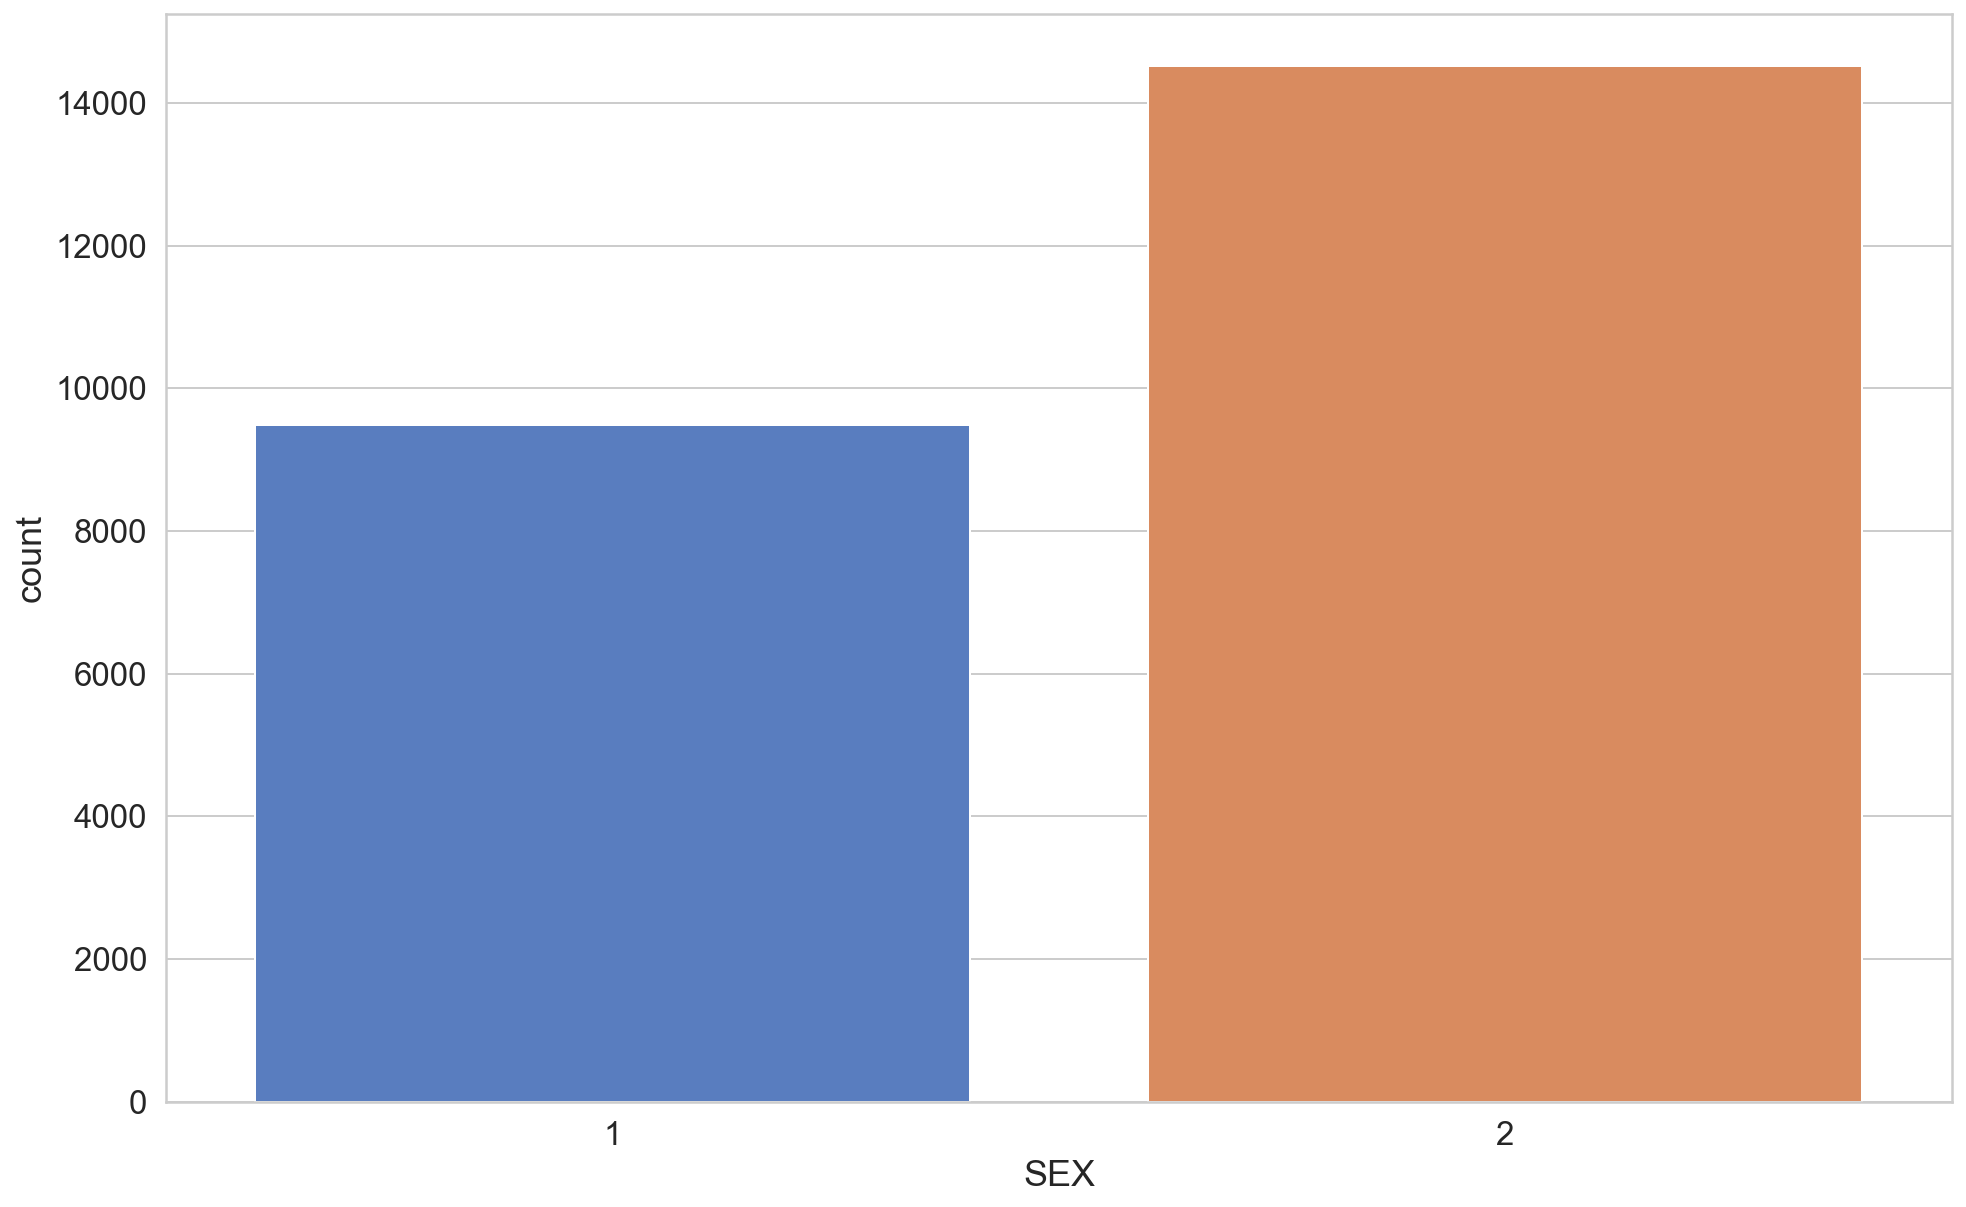

In [8]:
sns.countplot(X_train.SEX)

<AxesSubplot:xlabel='EDUCATION', ylabel='Count'>

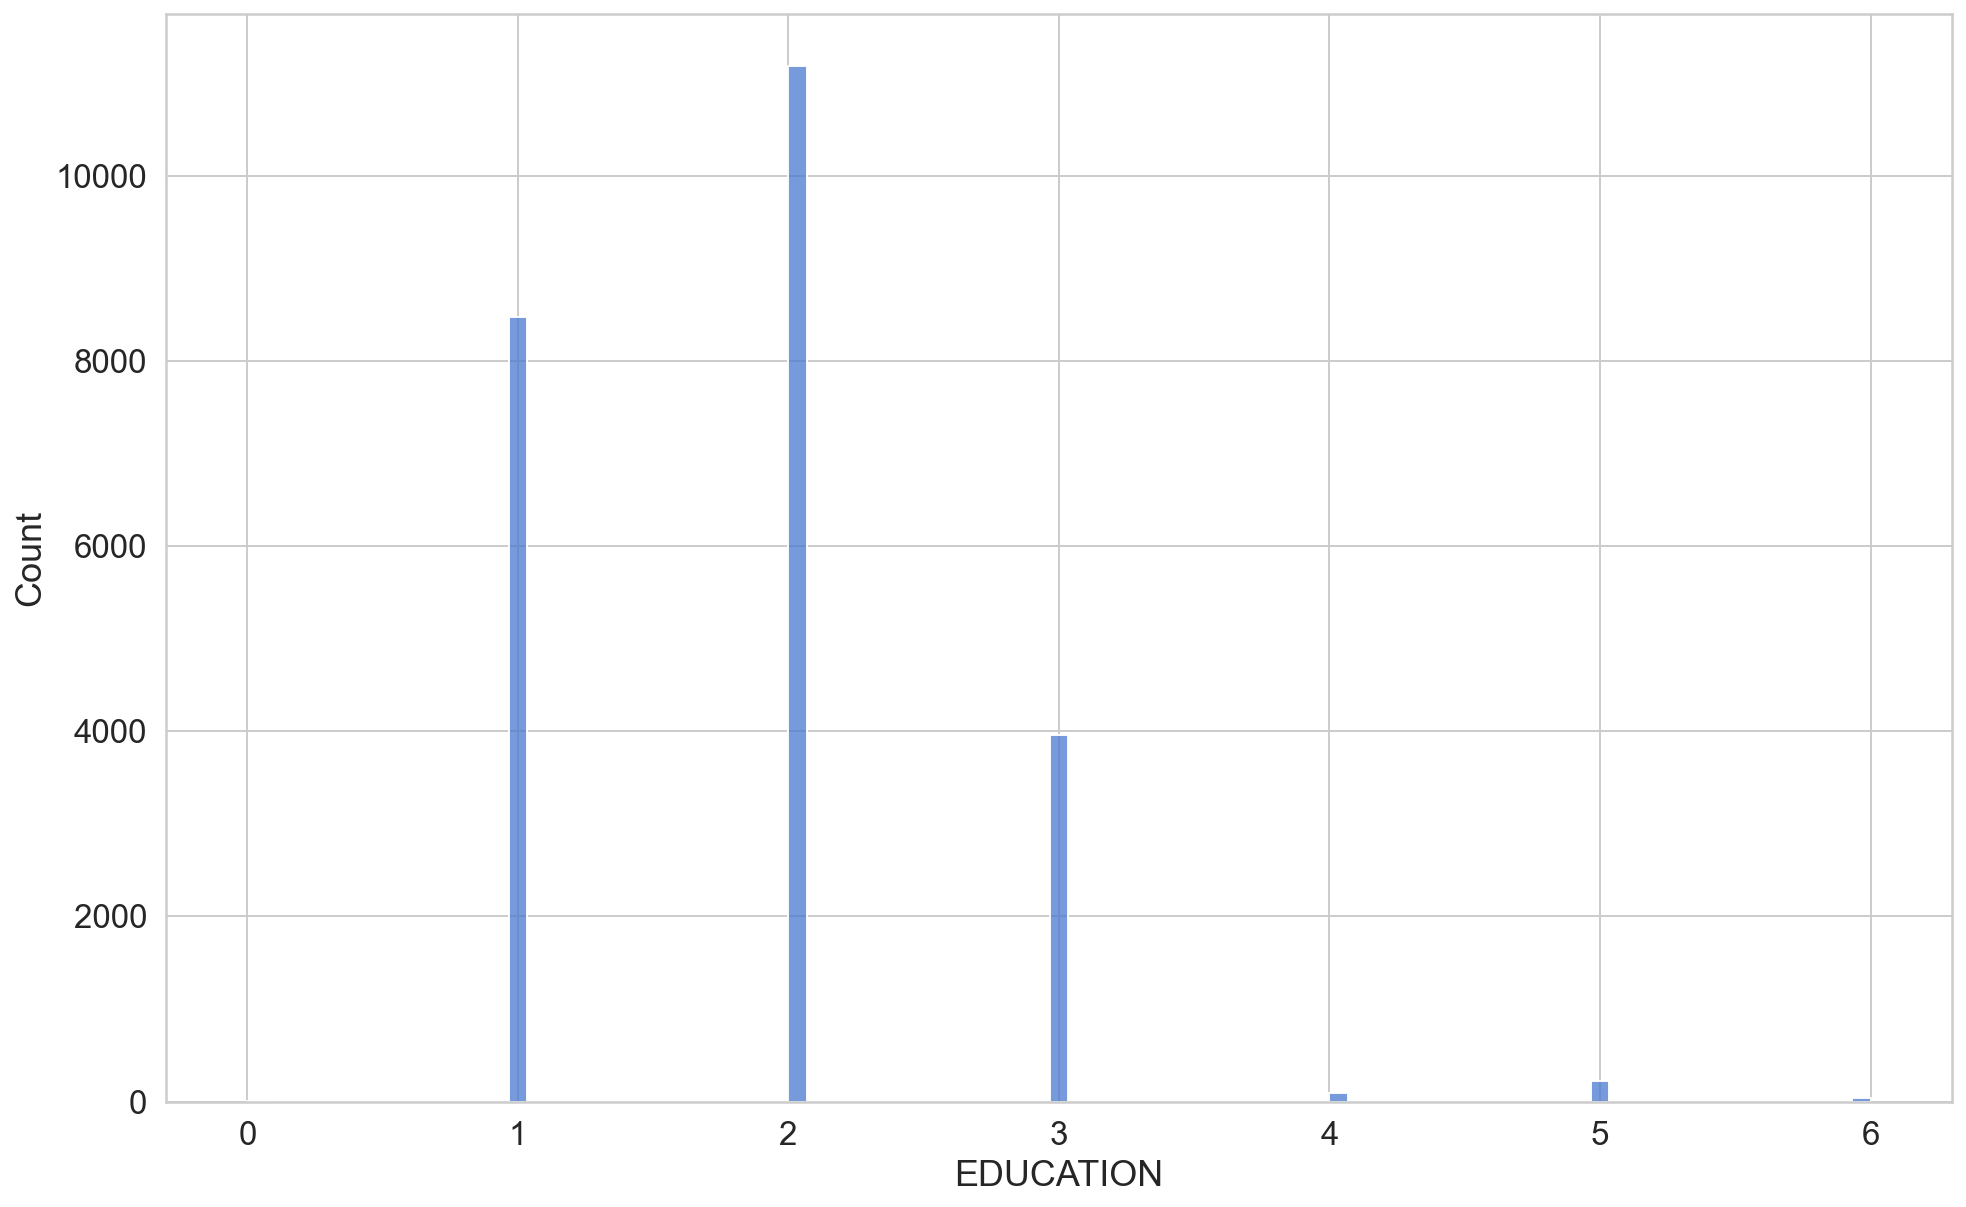

In [9]:
sns.histplot(X_train.EDUCATION)

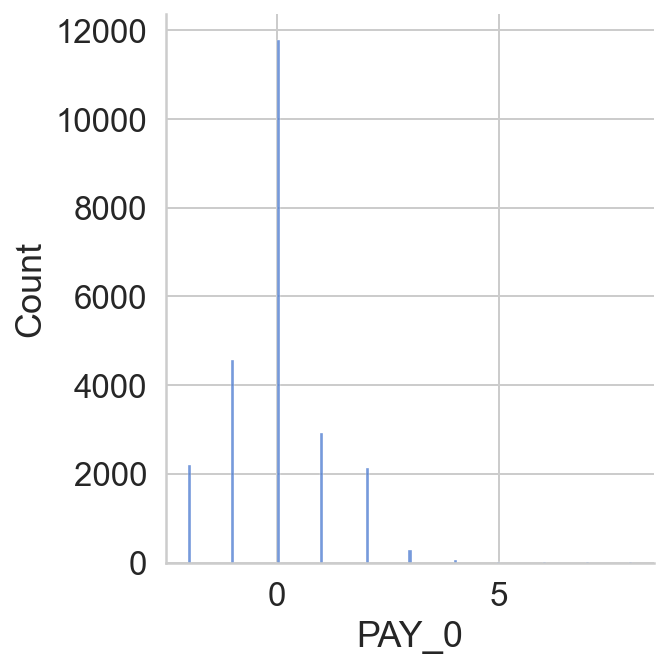

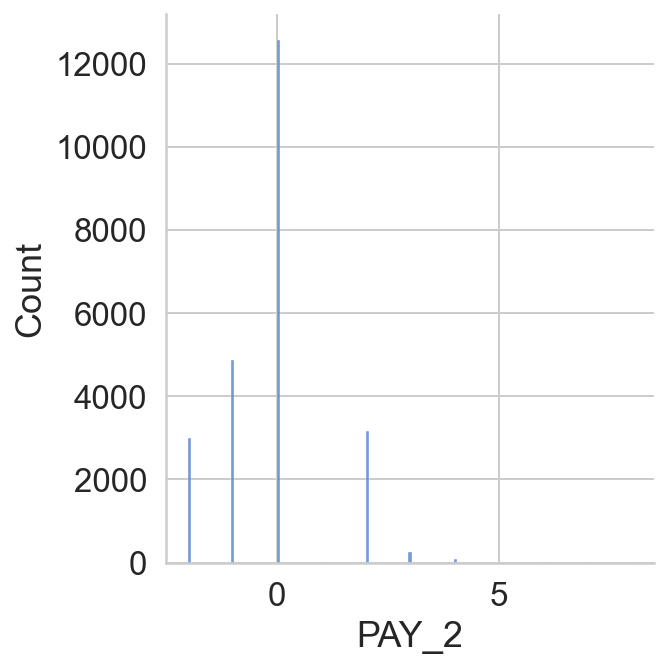

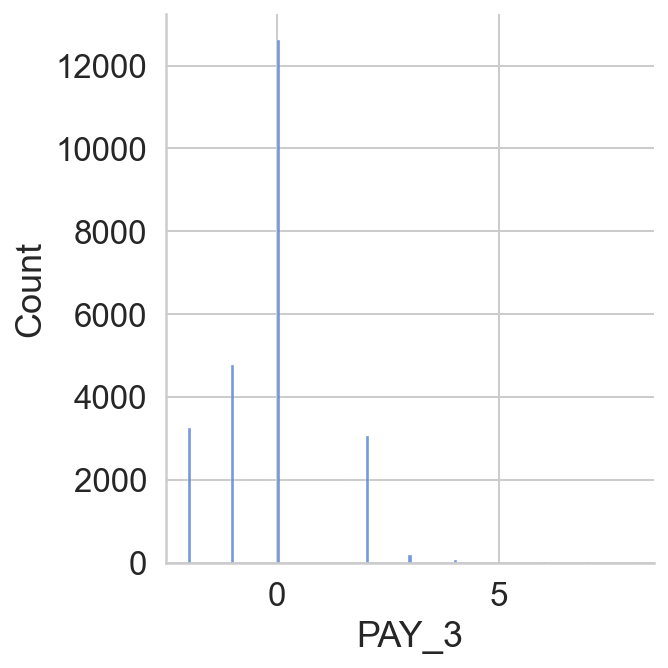

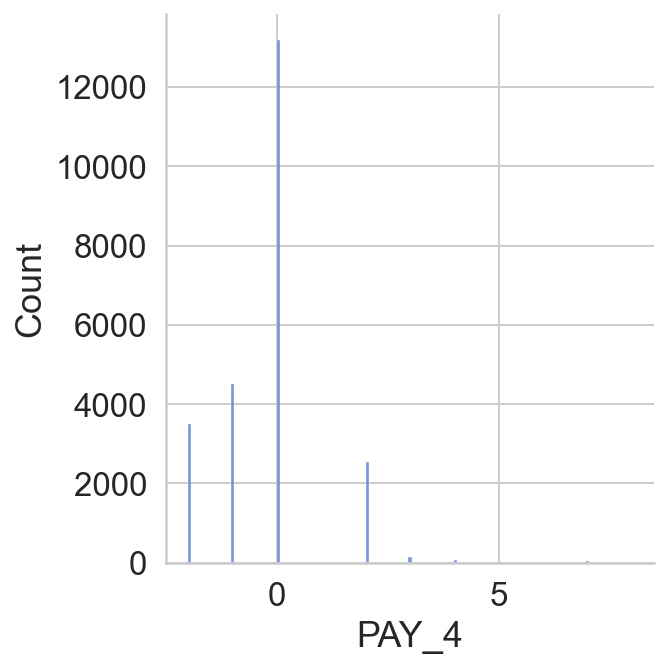

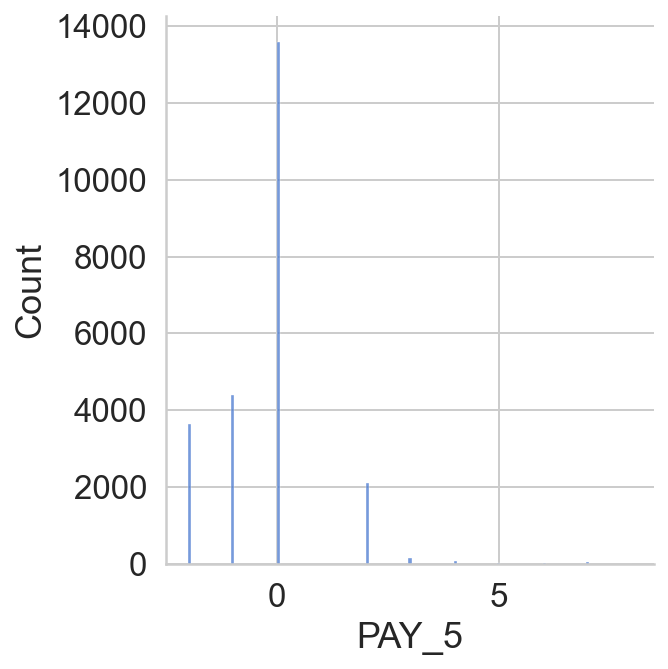

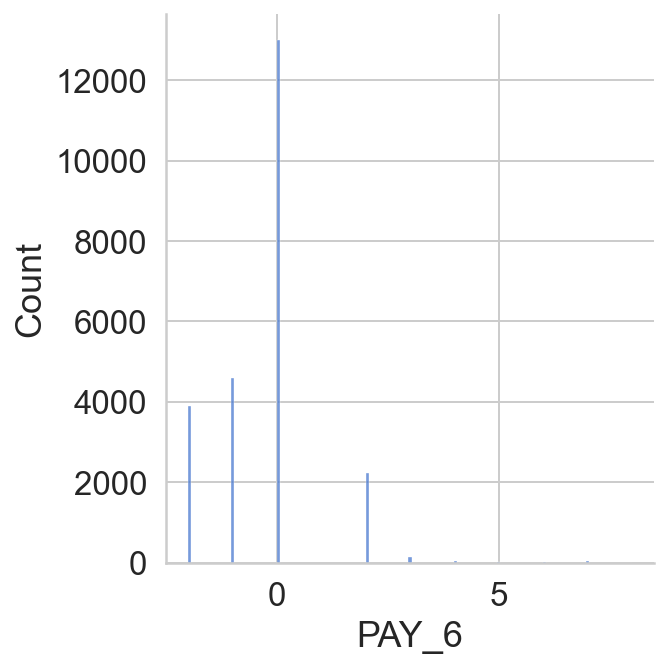

In [10]:
sns.displot(X_train.PAY_0)
sns.displot(X_train.PAY_2)
sns.displot(X_train.PAY_3)
sns.displot(X_train.PAY_4)
sns.displot(X_train.PAY_5)
sns.displot(X_train.PAY_6)

In [11]:
corr_matrix = X_train.corr()
corr_matrix_y = y_train.corr()

payment_corr = corr_matrix_y['default.payment.next.month']
payment_corr.iloc[payment_corr.abs().argsort()]

ID                           -0.010822
default.payment.next.month    1.000000
Name: default.payment.next.month, dtype: float64

<AxesSubplot:>

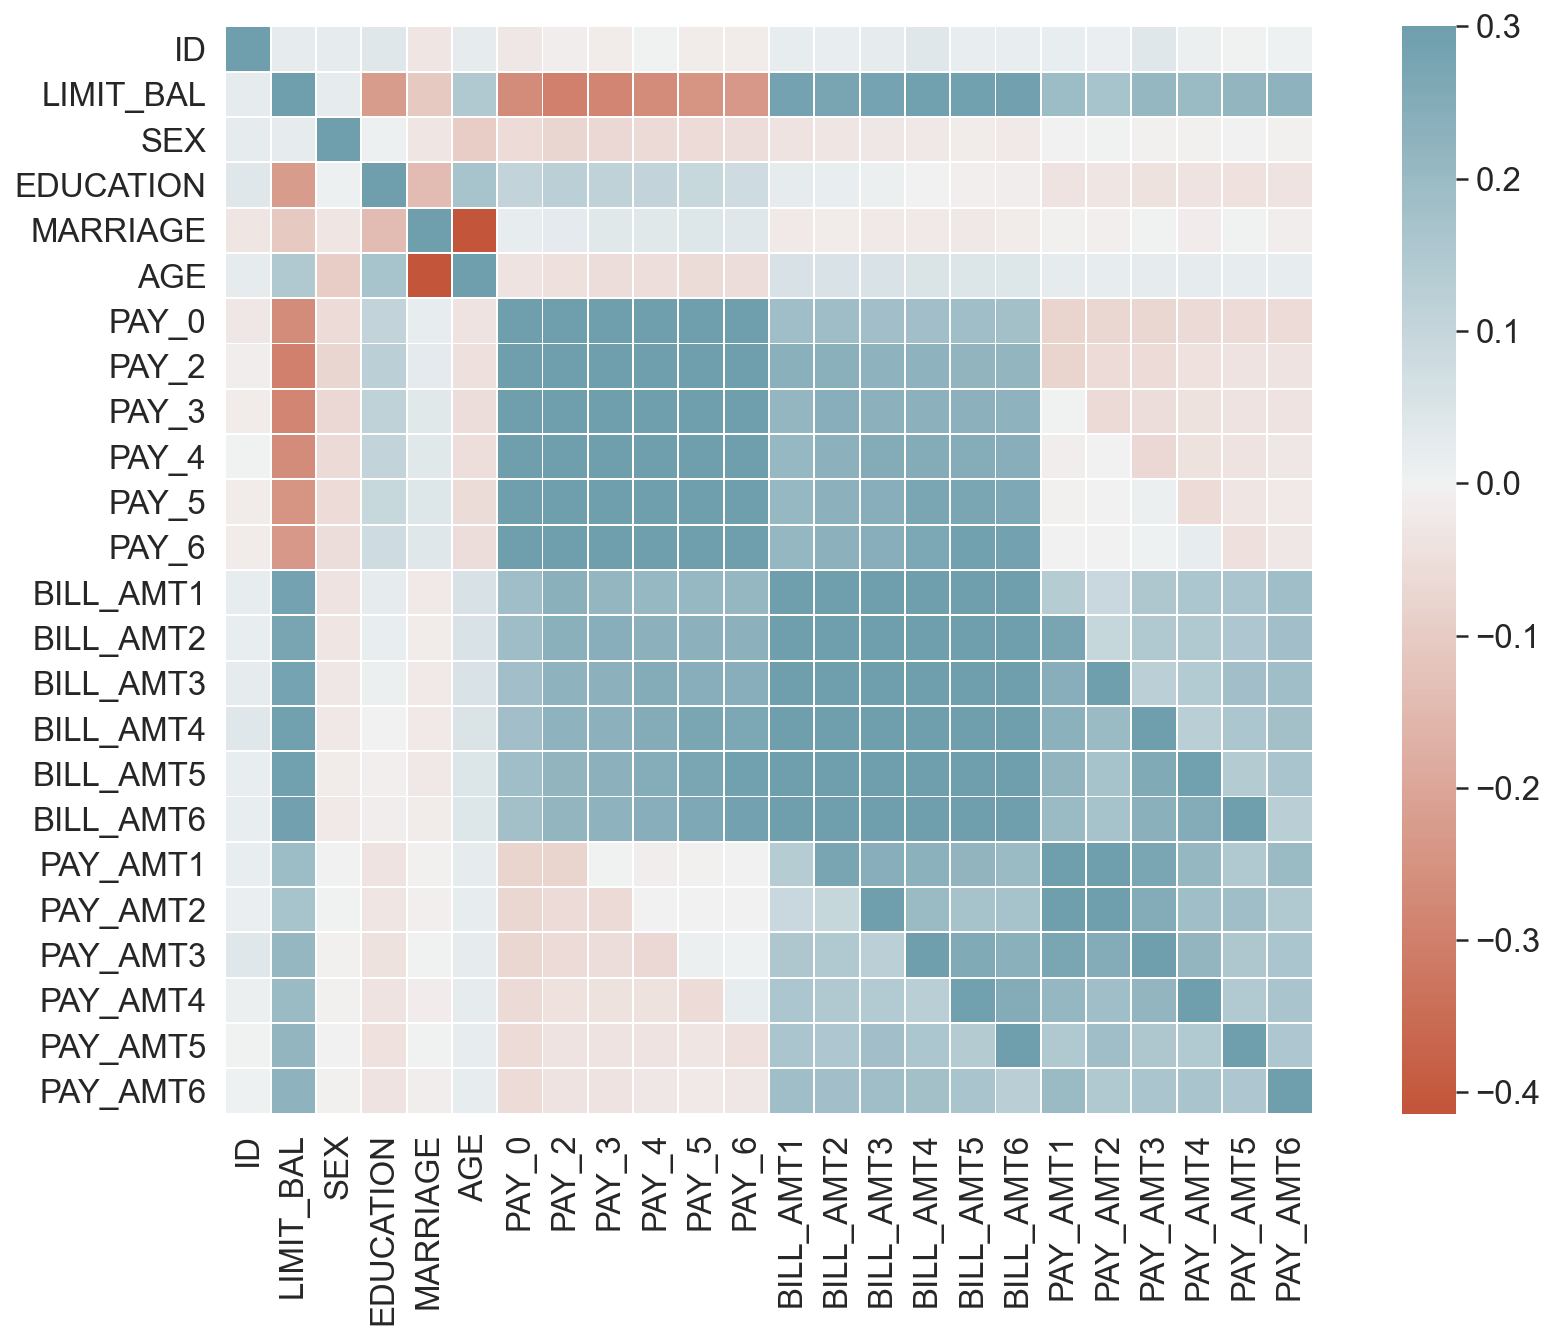

In [12]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5)

## Preprocessing

In [13]:
## First we verify if we have any missing data

missing = X_train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [14]:
missing_y = y_train.isnull().sum()
missing_y[missing_y > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [15]:
## Removal of unused columns
col2drop = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

X_train = X_train.drop(col2drop, axis=1)
X_test = X_test.drop(col2drop, axis=1)

In [16]:
X_train.head()

,ID,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,21754,2,2,2,24,75125.0,77353.0,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
1,252,1,2,2,28,29242.0,29507.0,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
2,22942,2,5,1,44,20916.0,0.0,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
3,619,1,1,2,25,58839.0,53235.0,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
4,17091,2,2,2,25,111587.0,112348.0,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [17]:
X_test.head()

,ID,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2309,1,2,2,25,8864.0,10062.0,11581.0,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0
1,22405,2,1,2,26,136736.0,125651.0,116684.0,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0
2,23398,2,3,1,32,70122.0,69080.0,68530.0,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0
3,25059,1,3,2,49,20678.0,18956.0,16172.0,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0
4,2665,2,2,2,36,94228.0,47635.0,42361.0,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0


## Feature scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

X = X_train
y = y_train['default.payment.next.month'].values
transformer = make_column_transformer(
    (MinMaxScaler(), X_train.columns))

In [19]:
transformer.fit(X)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 Index(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object'))])

In [20]:
# scaling
X = transformer.transform(X)

## Splitting the training and test data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape

(19200, 17)

# Neural Network Models

## 1. Neural Network with 3 layers

In [22]:
# The following method will help us plotting the F1-Score results
def plot_f1(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('F1')
  plt.plot(hist['epoch'], hist['loss'],
            label='Train F1')
  plt.plot(hist['epoch'], hist['val_loss'],
            label = 'Val F1')
  plt.legend()
  plt.show()

Epoch 1/100
480/480 [==============================] - 1s 3ms/step - loss: 0.5514 - binary_accuracy: 0.7781 - val_loss: 0.5397 - val_binary_accuracy: 0.7708
Epoch 2/100
480/480 [==============================] - 2s 3ms/step - loss: 0.5283 - binary_accuracy: 0.7781 - val_loss: 0.5384 - val_binary_accuracy: 0.7708
Epoch 3/100
480/480 [==============================] - 2s 4ms/step - loss: 0.5275 - binary_accuracy: 0.7781 - val_loss: 0.5377 - val_binary_accuracy: 0.7708
Epoch 4/100
480/480 [==============================] - 2s 4ms/step - loss: 0.5269 - binary_accuracy: 0.7781 - val_loss: 0.5376 - val_binary_accuracy: 0.7708
Epoch 5/100
480/480 [==============================] - 2s 5ms/step - loss: 0.5264 - binary_accuracy: 0.7781 - val_loss: 0.5371 - val_binary_accuracy: 0.7708
Epoch 6/100
480/480 [==============================] - 2s 4ms/step - loss: 0.5260 - binary_accuracy: 0.7781 - val_loss: 0.5367 - val_binary_accuracy: 0.7708
Epoch 7/100
480/480 [==============================] - 2s 

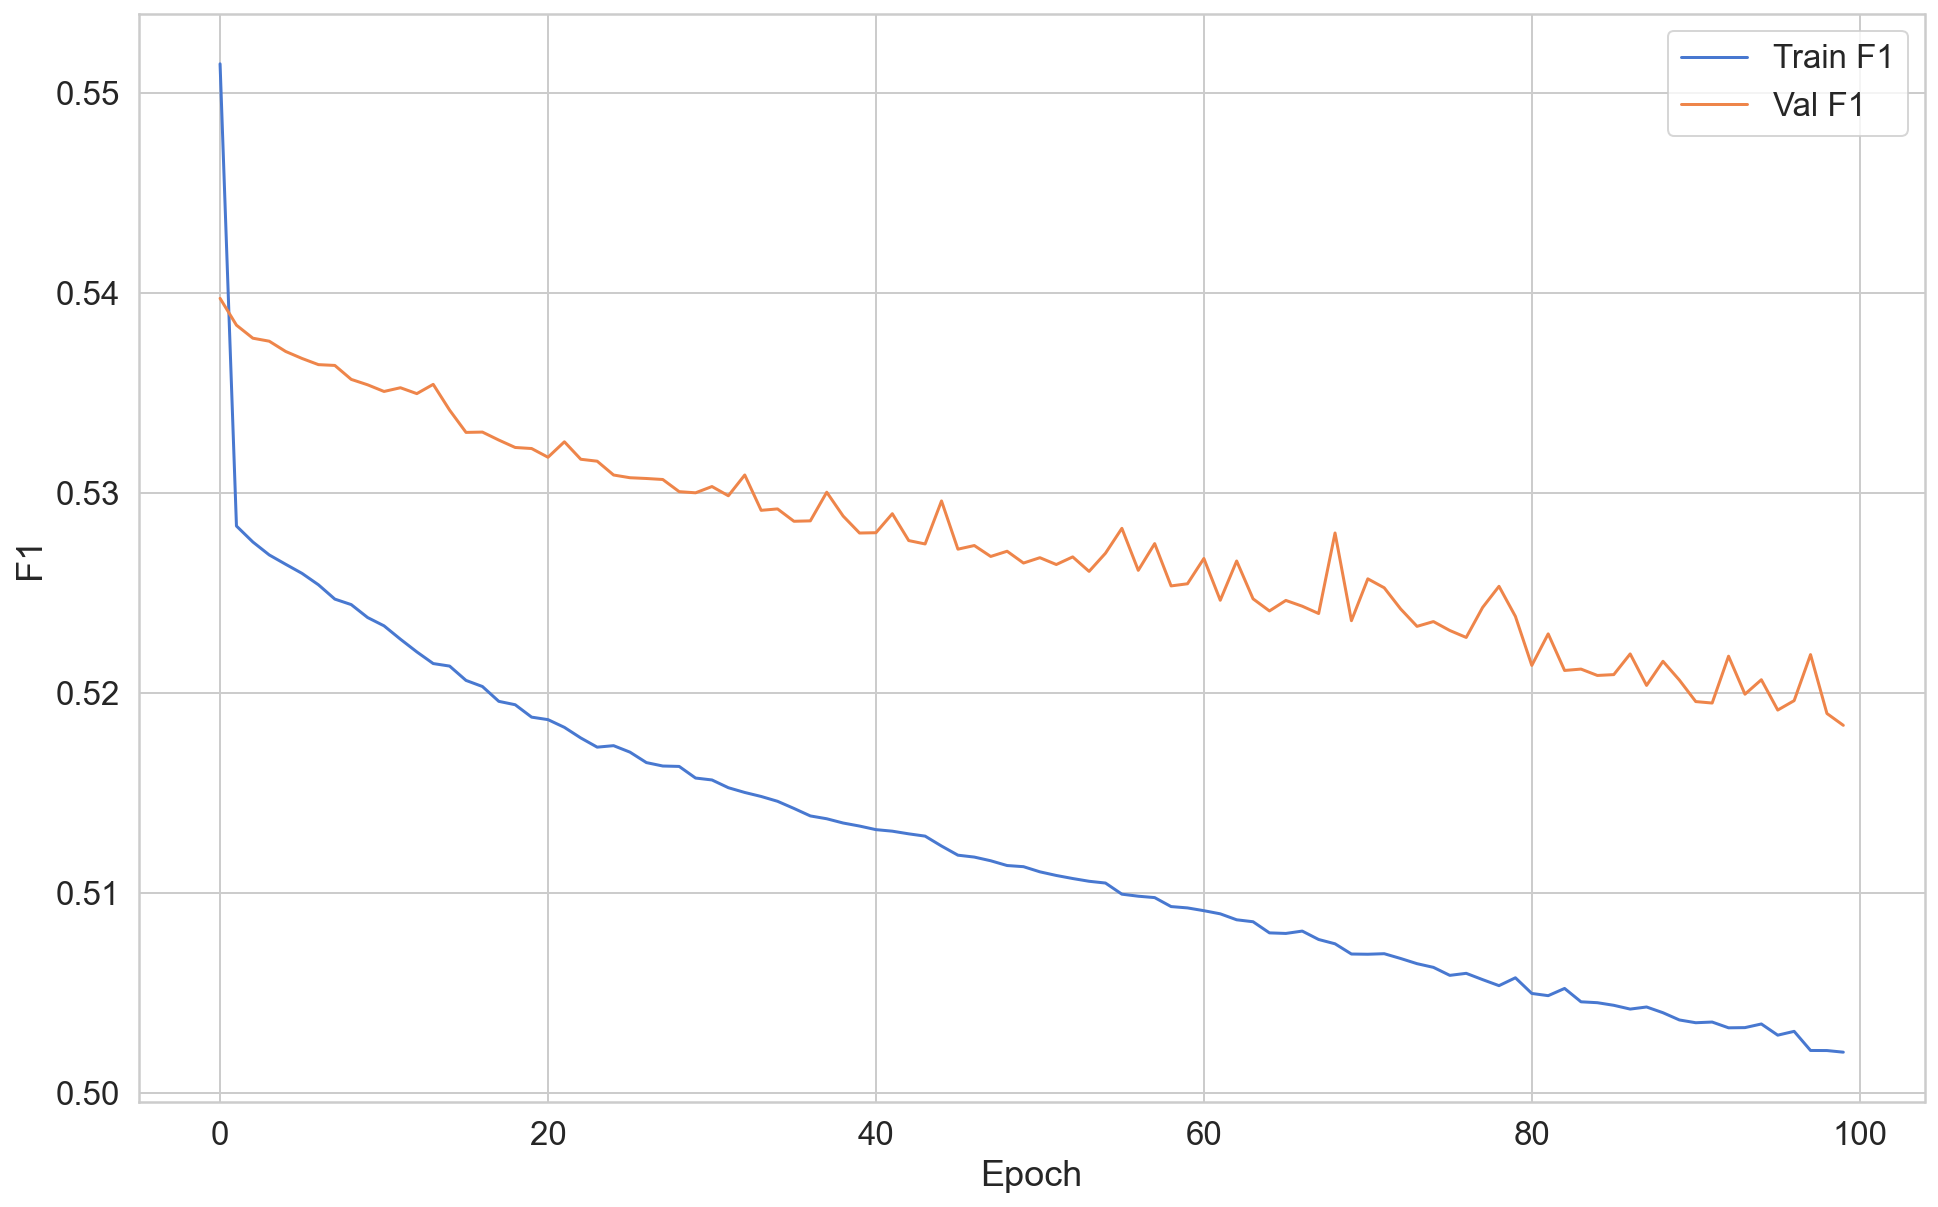

In [39]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(units=32, activation="relu", input_shape=[X_train.shape[1]]))
model1.add(keras.layers.Dense(units=64, activation="relu"))
model1.add(keras.layers.Dense(units=128, activation='relu'))

model1.add(keras.layers.Dense(1, activation="sigmoid"))

model1.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'binary_crossentropy', 
    metrics = ['binary_accuracy'])

BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=10
)

history = model1.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)

## 2. Neural Network with SGD Optimizer (4-layers)

ss: 0.5393 - val_binary_accuracy: 0.7708
Epoch 25/150
240/240 [==============================] - 1s 6ms/step - loss: 0.5293 - binary_accuracy: 0.7781 - val_loss: 0.5393 - val_binary_accuracy: 0.7708
Epoch 26/150
240/240 [==============================] - 1s 6ms/step - loss: 0.5293 - binary_accuracy: 0.7781 - val_loss: 0.5393 - val_binary_accuracy: 0.7708
Epoch 27/150
240/240 [==============================] - 1s 6ms/step - loss: 0.5293 - binary_accuracy: 0.7781 - val_loss: 0.5392 - val_binary_accuracy: 0.7708
Epoch 28/150
240/240 [==============================] - 1s 6ms/step - loss: 0.5292 - binary_accuracy: 0.7781 - val_loss: 0.5392 - val_binary_accuracy: 0.7708
Epoch 29/150
240/240 [==============================] - 1s 5ms/step - loss: 0.5292 - binary_accuracy: 0.7781 - val_loss: 0.5392 - val_binary_accuracy: 0.7708
Epoch 30/150
240/240 [==============================] - 2s 7ms/step - loss: 0.5291 - binary_accuracy: 0.7781 - val_loss: 0.5391 - val_binary_accuracy: 0.7708
Epoch 31/15

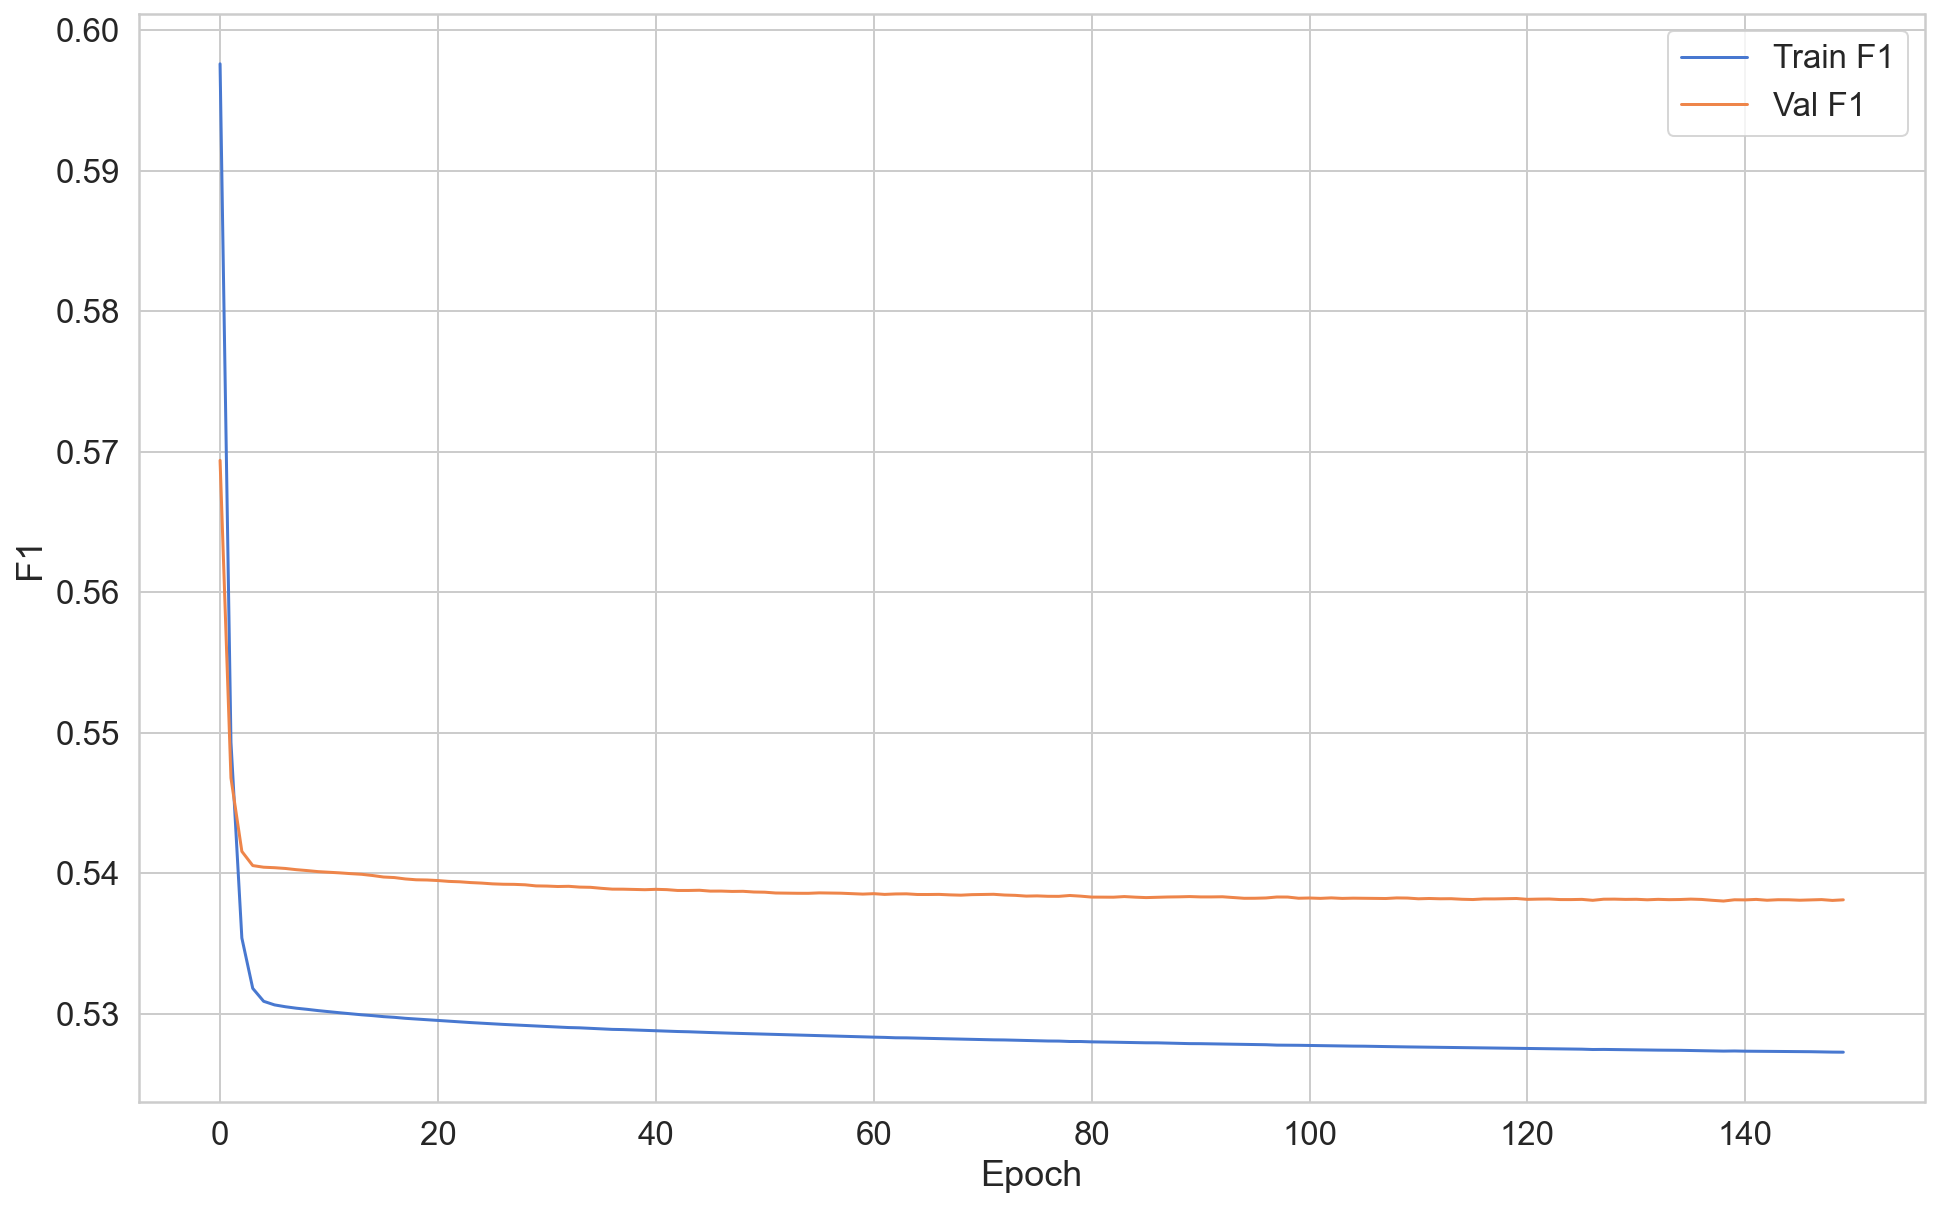

In [40]:
model2 = keras.Sequential()
model2.add(keras.layers.Dense(units=32, activation="relu", input_shape=[X_train.shape[1]]))
model2.add(keras.layers.Dense(units=64, activation="selu"))
model2.add(keras.layers.Dense(units=128, activation="selu"))
model2.add(keras.layers.Dense(units=256, activation="relu"))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.compile(
    optimizer=keras.optimizers.SGD(0.001),
    loss='binary_crossentropy', 
    metrics = ['binary_accuracy'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=10
)

history = model2.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=150,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)

## 3. Neural Network with 4 layers and Adagrad Optimizer

ss: 0.5394 - val_binary_accuracy: 0.7708
Epoch 25/150
240/240 [==============================] - 2s 7ms/step - loss: 0.5296 - binary_accuracy: 0.7781 - val_loss: 0.5394 - val_binary_accuracy: 0.7708
Epoch 26/150
240/240 [==============================] - 2s 7ms/step - loss: 0.5295 - binary_accuracy: 0.7781 - val_loss: 0.5394 - val_binary_accuracy: 0.7708
Epoch 27/150
240/240 [==============================] - 2s 7ms/step - loss: 0.5294 - binary_accuracy: 0.7781 - val_loss: 0.5393 - val_binary_accuracy: 0.7708
Epoch 28/150
240/240 [==============================] - 2s 7ms/step - loss: 0.5294 - binary_accuracy: 0.7781 - val_loss: 0.5393 - val_binary_accuracy: 0.7708
Epoch 29/150
240/240 [==============================] - 2s 7ms/step - loss: 0.5293 - binary_accuracy: 0.7781 - val_loss: 0.5393 - val_binary_accuracy: 0.7708
Epoch 30/150
240/240 [==============================] - 2s 7ms/step - loss: 0.5293 - binary_accuracy: 0.7781 - val_loss: 0.5393 - val_binary_accuracy: 0.7708
Epoch 31/15

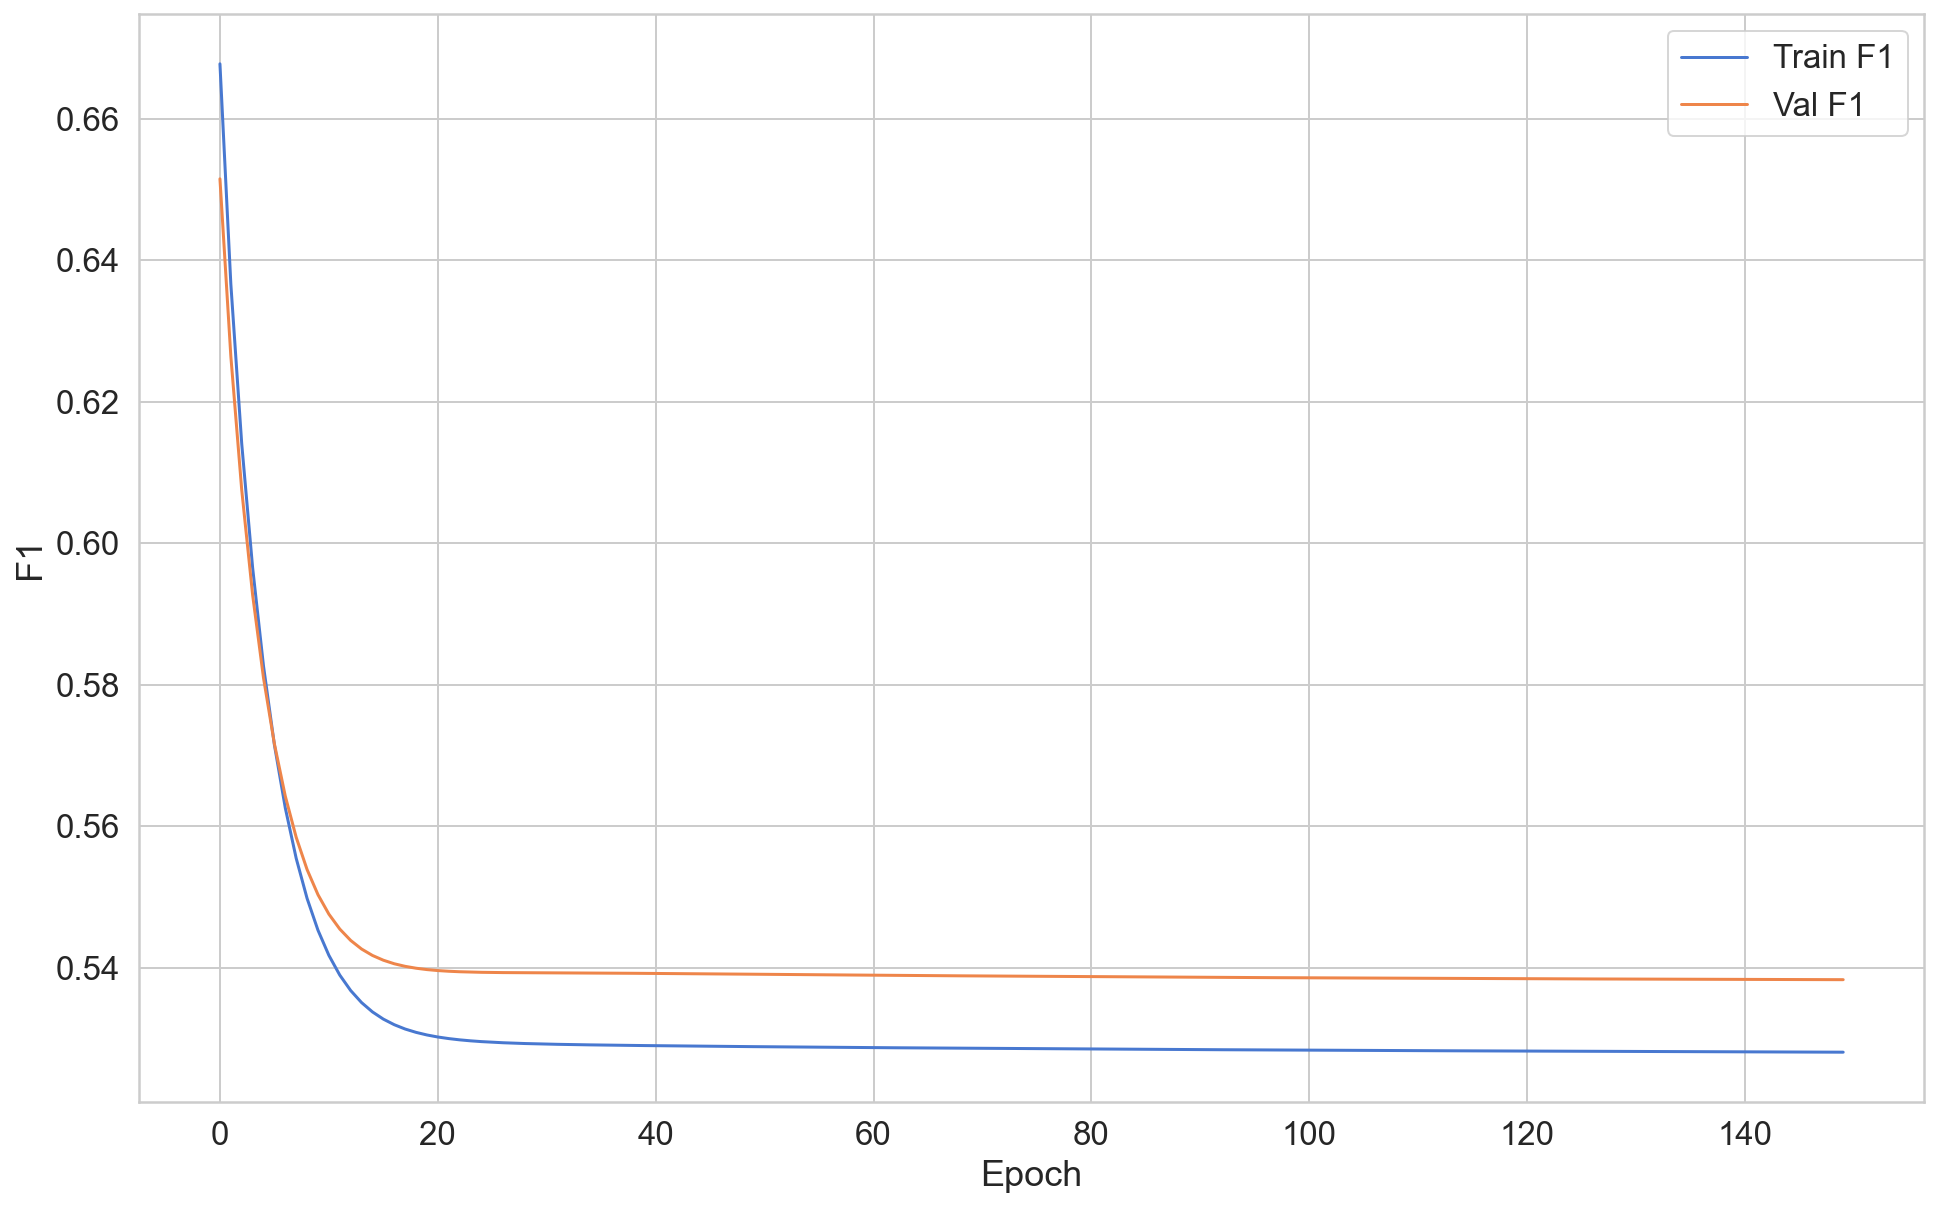

In [45]:
model3 = keras.Sequential()
model3.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model3.add(keras.layers.Dense(units=128, activation="linear"))
model3.add(keras.layers.Dense(units=256, activation="selu"))
model3.add(keras.layers.Dense(units=512, activation="relu"))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.compile(
    optimizer=keras.optimizers.Adagrad(0.0001),
    loss='binary_crossentropy', 
    metrics = ['binary_accuracy'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=10
)

history = model3.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=150,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)

## 4. Neural Network with dropout regularization at 30%

Epoch 1/100
240/240 [==============================] - 2s 8ms/step - loss: 0.6842 - binary_accuracy: 0.6005 - val_loss: 0.6878 - val_binary_accuracy: 0.7622
Epoch 2/100
240/240 [==============================] - 2s 6ms/step - loss: 0.6780 - binary_accuracy: 0.6622 - val_loss: 0.6820 - val_binary_accuracy: 0.7708
Epoch 3/100
240/240 [==============================] - 1s 6ms/step - loss: 0.6717 - binary_accuracy: 0.7070 - val_loss: 0.6764 - val_binary_accuracy: 0.7708
Epoch 4/100
240/240 [==============================] - 3s 11ms/step - loss: 0.6660 - binary_accuracy: 0.7370 - val_loss: 0.6709 - val_binary_accuracy: 0.7708
Epoch 5/100
240/240 [==============================] - 2s 7ms/step - loss: 0.6606 - binary_accuracy: 0.7536 - val_loss: 0.6658 - val_binary_accuracy: 0.7708
Epoch 6/100
240/240 [==============================] - 2s 6ms/step - loss: 0.6553 - binary_accuracy: 0.7654 - val_loss: 0.6608 - val_binary_accuracy: 0.7708
Epoch 7/100
240/240 [==============================] - 2s

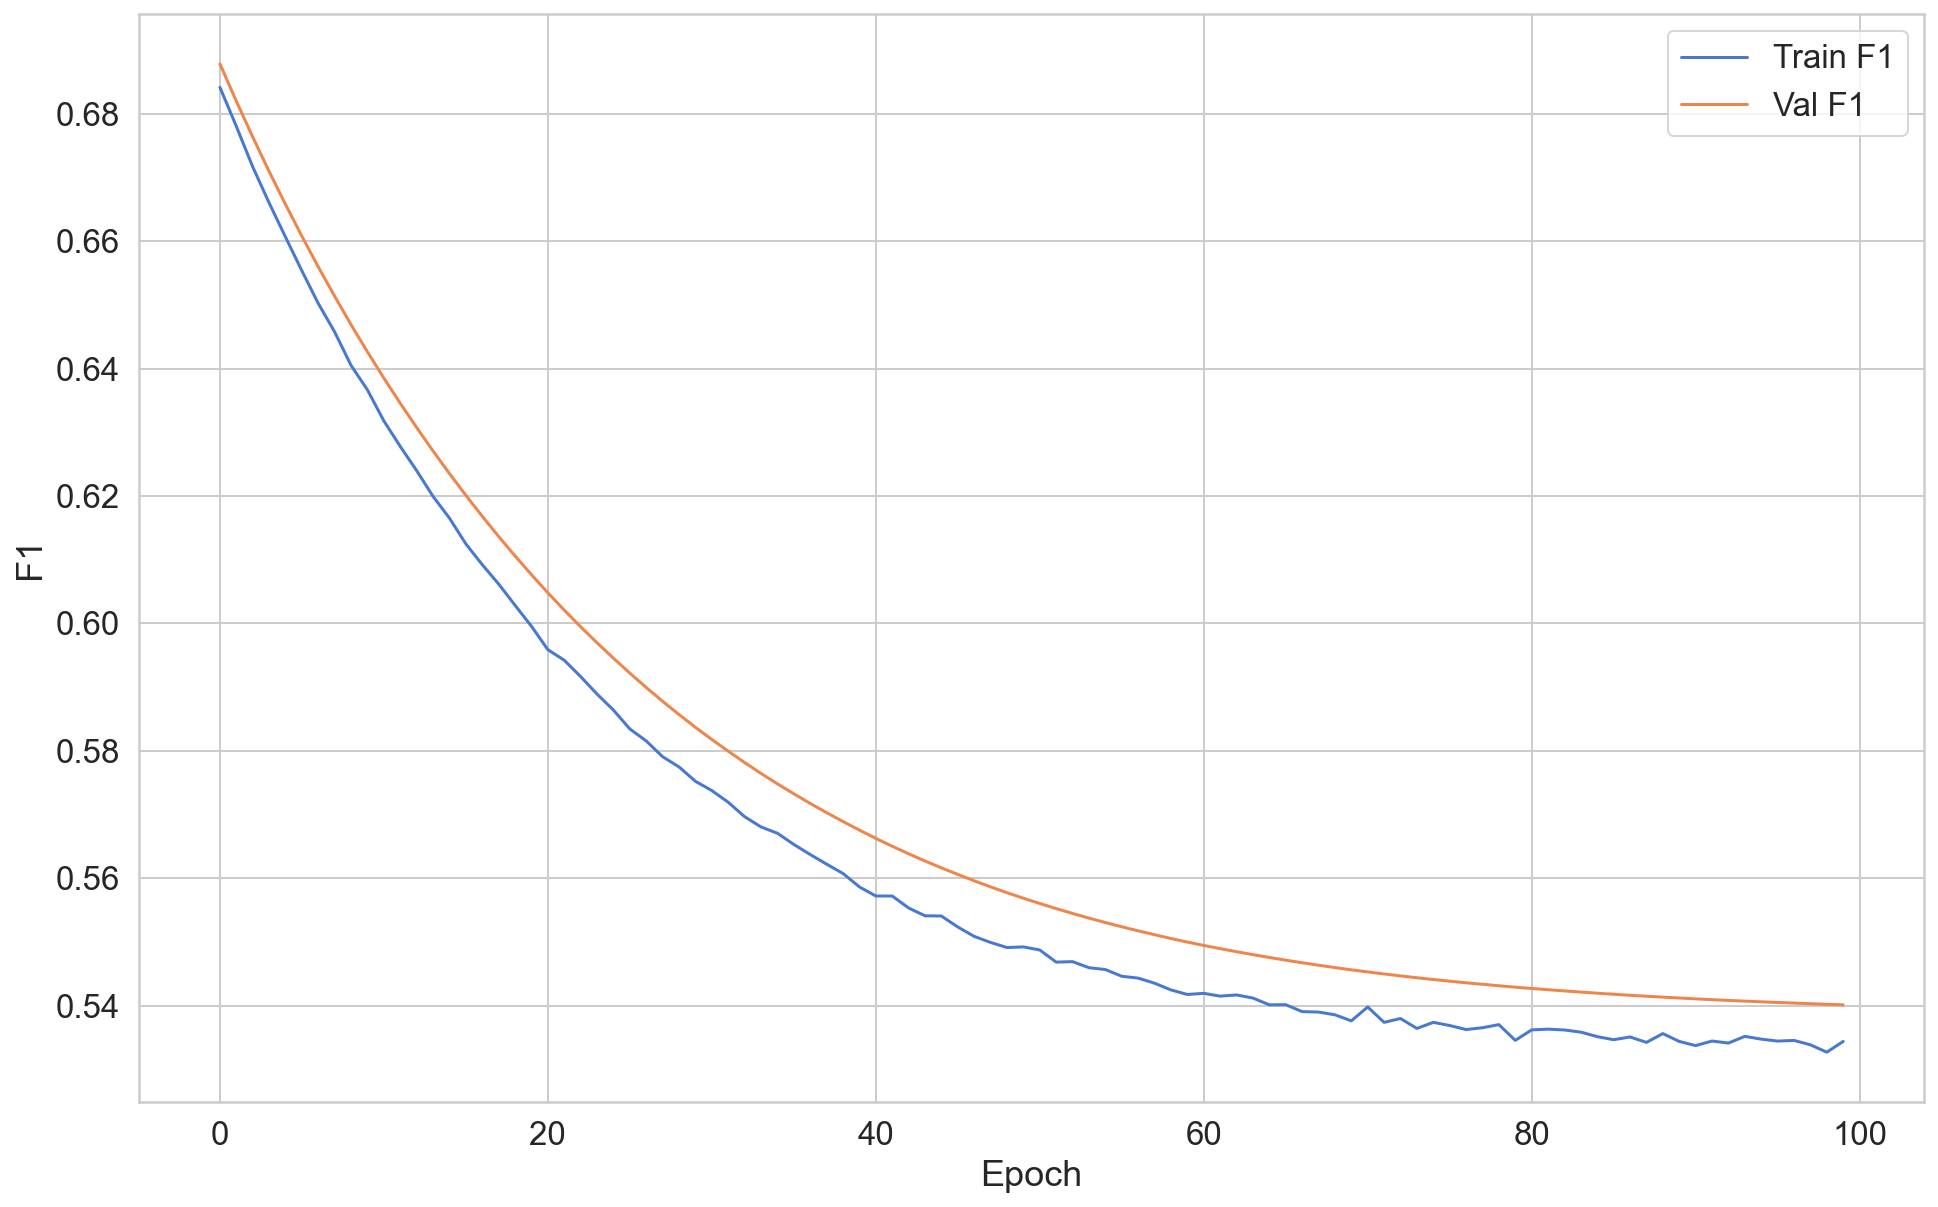

In [50]:
model4 = keras.Sequential()
model4.add(keras.layers.Dropout(0.3, input_shape=(X_train.shape[1],)))
model4.add(keras.layers.Dense(units=128, activation="relu"))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(units=256, activation="relu"))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(units=512, activation="relu"))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.compile(
    optimizer=keras.optimizers.SGD(0.0001),
    loss = 'binary_crossentropy', 
    metrics = ['binary_accuracy'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=15
)

history = model4.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)